<a href="https://colab.research.google.com/github/Amrutha369/voice-spoofing-detection/blob/main/voice_spoofing_detection_Multiclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing


In [3]:
!pip install scikeras

In [4]:

!pip install tensorflow-io
import os
import pandas as pd # data manipulation and analysis
import matplotlib.pyplot as plt #plotting library
import numpy as np #numerical computing
import tensorflow as tf
import seaborn as sns # statistical data visualization
from IPython.display import Audio
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [5]:
# Audio params
SAMPLE_RATE = 16000

# Spectrogram params
N_MELS = 128 # freq axis
SPEC_WIDTH = 256 #


# CNN params
NUM_CLASSES = 4 # real,synthesised, converted, replay


In [6]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Directory and protocol definitions
base_path = '/content/drive/MyDrive/dataset/LA'
protocol_dir = os.path.join(base_path, 'ASVspoof2019_LA_cm_protocols')
train_dir = os.path.join(base_path, 'ASVspoof2019_LA_train', 'flac')
val_dir = os.path.join(base_path, 'ASVspoof2019_LA_dev', 'flac')
test_dir = os.path.join(base_path, 'ASVspoof2019_LA_eval', 'flac')

In [8]:
# Function to form the full path of a file
def get_file_path(directory, filename):
    return os.path.join(directory, f'{filename}.flac')

In [9]:
# Function to read the dataset
def read_dataset(protocol_path, directory):
    """Reads the dataset from a protocol file and returns a DataFrame."""
    df = pd.read_csv(protocol_path, sep=' ', header=None, names=['speaker_id', 'filename', 'system_id', 'null', 'class_name'])
    df['filepath'] = df['filename'].apply(lambda x: get_file_path(directory, x))
    df.drop('null', axis=1, inplace=True)
    df.dropna(inplace=True)
    return df

# Function to convert class_name to integer
def label_to_int(class_name):
    if class_name == 'real':
        return 0
    elif class_name == 'synthesised':
        return 1
    elif class_name == 'converted':
        return 2
    elif class_name == 'replay':
        return 3
    else:
        return -1  # Handle unknown classes

# Add target column and subset to DataFrame
def add_columns(df, subset):
    df['target'] = df['class_name'].apply(label_to_int)
    df['subset'] = subset
    return df

# Take samples from each DataFrame
def sample_data_multiclass(df, n_synthesised, n_real, n_converted, n_replay):
    synthesised = df[df['class_name'] == 'synthesised'].head(n_synthesised)
    real = df[df['class_name'] == 'real'].head(n_real)
    converted = df[df['class_name'] == 'converted'].head(n_converted)
    replay = df[df['class_name'] == 'replay'].head(n_replay)
    return pd.concat([synthesised, real, converted, replay])

# Directory and protocol definitions
base_path = '/content/drive/MyDrive/dataset/LA'
protocol_dir = os.path.join(base_path, 'ASVspoof2019_LA_cm_protocols')
train_dir = os.path.join(base_path, 'ASVspoof2019_LA_train', 'flac')
val_dir = os.path.join(base_path, 'ASVspoof2019_LA_dev', 'flac')
test_dir = os.path.join(base_path, 'ASVspoof2019_LA_eval', 'flac')

# Create DataFrames for each dataset
train_df = read_dataset(os.path.join(protocol_dir, 'ASVspoof2019.LA.cm.train.trn.txt'), train_dir)
val_df = read_dataset(os.path.join(protocol_dir, 'ASVspoof2019.LA.cm.dev.trl.txt'), val_dir)
test_df = read_dataset(os.path.join(protocol_dir, 'ASVspoof2019.LA.cm.eval.trl.txt'), test_dir)

# Add columns to each DataFrame
train_df = add_columns(train_df, 'train')
val_df = add_columns(val_df, 'val')
test_df = add_columns(test_df, 'test')

# Take samples from each DataFrame by a different number
train_df = sample_data_multiclass(train_df, 175, 175, 175,175)
val_df = sample_data_multiclass(val_df, 37, 37, 37,37)
test_df = sample_data_multiclass(test_df, 37, 37, 37,37)

In [10]:
#Combine three dataframes into one dataframe
data_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

# Feature extraction

In [11]:
import librosa

def audio_to_spectrogram(filepath):
    # Load audio file using librosa
    audio, sample_rate = librosa.load(filepath)

    # Normalize the audio
    audio_norm = (audio - np.min(audio)) / (np.max(audio) - np.min(audio))
    # A spectrogram is a visual representation of the spectrum of frequencies of a signal as it varies with time.
    # Compute the spectrogram using librosa
    spectrogram = librosa.feature.melspectrogram(y=audio_norm, sr=sample_rate)

    # Convert the spectrogram to decibels
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

    # Add channel dimension
    spectrogram_db = np.expand_dims(spectrogram_db, axis=-1)

    # Resize spectrogram to the specified size
    image = tf.image.resize(spectrogram_db, [SPEC_WIDTH, N_MELS])

    return image

# Adding the spectrogram column to the DataFrame
data_df['spectrogram'] = data_df['filepath'].apply(audio_to_spectrogram)


In [12]:
# Splitting the data based on the 'subset' column
train_data = data_df[data_df['subset'] == 'train']
val_data = data_df[data_df['subset'] == 'val']
test_data = data_df[data_df['subset'] == 'test']

# Converting the list of spectrograms into NumPy arrays
X_train = np.stack(train_data['spectrogram'].to_list())
X_val = np.stack(val_data['spectrogram'].to_list())
X_test = np.stack(test_data['spectrogram'].to_list())

# Converting target into NumPy arrays
y_train = train_data['target'].to_numpy()
y_val = val_data['target'].to_numpy()
y_test = test_data['target'].to_numpy()

# CNN Model (Multiclass)

In [13]:
from tensorflow.keras.optimizers import Adam

def cnn_model(input_shape, num_classes):
    model = Sequential()
    # 1st conv layer
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    # 2nd conv layer
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    # 3rd conv layer
    model.add(Conv2D(32, (2, 2), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    # 4th conv layer
    model.add(Conv2D(64, (2, 2), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    # Additional dense layer
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    # Output layer for multiclass classification
    model.add(Dense(num_classes, activation='softmax'))
    # Compile the model with Adam optimizer
    optimizer = Adam(learning_rate=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Convert target labels to one-hot encoding for multiclass classification
from tensorflow.keras.utils import to_categorical
# Convert target labels to one-hot encoding
y_train_categorical = to_categorical(y_train, num_classes=NUM_CLASSES)
y_val_categorical = to_categorical(y_val, num_classes=NUM_CLASSES)
y_test_categorical = to_categorical(y_test, num_classes=NUM_CLASSES)


# Create the multiclass CNN model with Adam optimizer
multiclass_cnn_model =cnn_model((X_train.shape[1], X_train.shape[2], 1), NUM_CLASSES)




/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [ ]:
# Train the multiclass CNN model
multiclass_cnn_model.fit(X_train, y_train_categorical, epochs=50, batch_size=16)


Epoch 1/50
44/44 [==============================] - 4s 15ms/step - loss: 1.3828 - accuracy: 0.4286
Epoch 2/50
44/44 [==============================] - 1s 13ms/step - loss: 0.9373 - accuracy: 0.6057
Epoch 3/50
44/44 [==============================] - 1s 13ms/step - loss: 0.7780 - accuracy: 0.6771
Epoch 4/50
44/44 [==============================] - 1s 14ms/step - loss: 0.6720 - accuracy: 0.7371
Epoch 5/50
44/44 [==============================] - 1s 13ms/step - loss: 0.6066 - accuracy: 0.7429
Epoch 6/50
44/44 [==============================] - 1s 15ms/step - loss: 0.5517 - accuracy: 0.7686
Epoch 7/50
44/44 [==============================] - 1s 15ms/step - loss: 0.4423 - accuracy: 0.8257
Epoch 8/50
44/44 [==============================] - 1s 14ms/step - loss: 0.3558 - accuracy: 0.8643
Epoch 9/50
44/44 [==============================] - 1s 15ms/step - loss: 0.3476 - accuracy: 0.8629
Epoch 10/50
44/44 [==============================] - 1s 14ms/step - loss: 0.2691 - accuracy: 0.8957
Epoch 11/

In [ ]:
# Compute accuracy on training data
train_accuracy = multiclass_cnn_model.evaluate(X_train, y_train_categorical)[1]
print(f"Accuracy on training data: {train_accuracy * 100:.2f}%")

# Compute accuracy on validation data
val_accuracy = multiclass_cnn_model.evaluate(X_val, y_val_categorical)[1]
print(f'Accuracy on validation data: {val_accuracy * 100:.2f}%')

# Compute accuracy on test data
test_accuracy = multiclass_cnn_model.evaluate(X_test, y_test_categorical)[1]
print(f'Accuracy on test data: {test_accuracy * 100:.2f}%')


22/22 [==============================] - 0s 10ms/step - loss: 1.6016e-04 - accuracy: 1.0000
Accuracy on training data: 100.00%
5/5 [==============================] - 0s 10ms/step - loss: 0.1976 - accuracy: 0.9527
Accuracy on validation data: 95.27%
5/5 [==============================] - 0s 8ms/step - loss: 0.0508 - accuracy: 0.9932
Accuracy on test data: 99.32%


In [ ]:
from sklearn.metrics import classification_report, precision_recall_fscore_support
import numpy as np


# Predict probabilities on the test set for multiclass classification
y_pred_prob_multiclass = multiclass_cnn_model.predict(X_test)
y_pred_classes_multiclass = np.argmax(y_pred_prob_multiclass, axis=1)

# Convert one-hot encoded test labels back to integer format for multiclass classification
y_test_int = np.argmax(y_test_categorical, axis=1)


# Generate classification report for multiclass classification
report_multiclass = classification_report(y_test_int, y_pred_classes_multiclass, target_names=class_labels)
print("\nMulticlass Classification Report:")
print(report_multiclass)


5/5 [==============================] - 3s 542ms/step

Multiclass Classification Report:
              precision    recall  f1-score   support

        real       1.00      0.97      0.99        37
 synthesised       1.00      1.00      1.00        37
   converted       0.97      1.00      0.99        37
      replay       1.00      1.00      1.00        37

    accuracy                           0.99       148
   macro avg       0.99      0.99      0.99       148
weighted avg       0.99      0.99      0.99       148



In [ ]:
# Save the model
multiclass_cnn_model.save('/content/drive/MyDrive/save/voice-spoofing-detection-using-cnn-Multiclass.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
import os
from tensorflow.keras.models import load_model

sample_audio_file_path = "/content/drive/MyDrive/dataset/LA/ASVspoof2019_LA_eval/flac/LA_T_7686633.flac"

model_path = "/content/drive/MyDrive/save/voice-spoofing-detection-using-cnn-Multiclass.h5"
multiclass_cnn_model = load_model(model_path)
# Creating spectrogram for the sample audio file
sample_audio_spectrogram = audio_to_spectrogram(sample_audio_file_path)
X_new = np.expand_dims(sample_audio_spectrogram, axis=0)

# Performing prediction
y_pred = multiclass_cnn_model.predict(X_new)

# Convert probabilities to classes by selecting the class with the highest probability
y_pred_classes = np.argmax(y_pred, axis=1)

# Map predicted classes to labels
class_labels = ['real', 'synthesised', 'converted','replay']  # Update with your actual class labels
y_pred_labels = [class_labels[pred] for pred in y_pred_classes]
print("Predicted class:", y_pred_labels[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted class: real


5/5 [==============================] - 4s 565ms/step


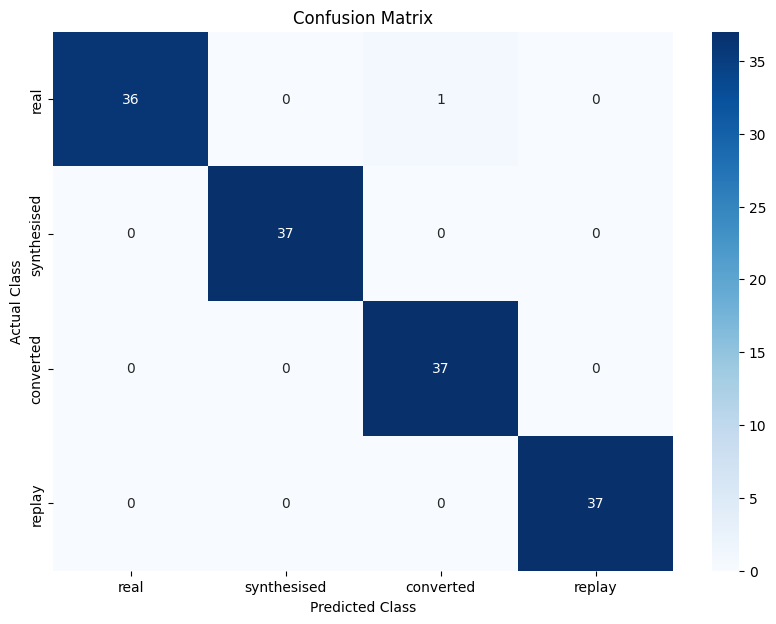

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have X_eval and y_eval datasets for testing

# Perform predictions on the evaluation set
y_test_pred = multiclass_cnn_model.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_test_pred_classes)

# Create a heatmap plot
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')

# Show the plot
plt.show()


# LSTM Model

In [15]:
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

from sklearn.metrics import classification_report

# architecture of the Sequential LSTM model
model = Sequential([
    LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(128),
    Dropout(0.2),
    Dense(4, activation='softmax')  # Assuming 4 classes for multiclass classification
])

# Compile the model
learning_rate = 0.0001  # Adjust the learning rate as needed

# Compile the model with custom learning rate
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])





/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_val, y_val))



Epoch 1/100
44/44 [==============================] - 8s 60ms/step - loss: 1.3829 - accuracy: 0.2786 - val_loss: 1.3574 - val_accuracy: 0.4324
Epoch 2/100
44/44 [==============================] - 1s 33ms/step - loss: 1.3269 - accuracy: 0.3529 - val_loss: 1.2050 - val_accuracy: 0.4324
Epoch 3/100
44/44 [==============================] - 2s 44ms/step - loss: 1.1031 - accuracy: 0.4657 - val_loss: 0.9057 - val_accuracy: 0.5541
Epoch 4/100
44/44 [==============================] - 3s 60ms/step - loss: 1.0226 - accuracy: 0.4757 - val_loss: 0.8802 - val_accuracy: 0.5203
Epoch 5/100
44/44 [==============================] - 2s 49ms/step - loss: 1.0120 - accuracy: 0.4714 - val_loss: 0.8885 - val_accuracy: 0.5135
Epoch 6/100
44/44 [==============================] - 2s 53ms/step - loss: 0.9392 - accuracy: 0.5014 - val_loss: 0.8830 - val_accuracy: 0.5203
Epoch 7/100
44/44 [==============================] - 2s 51ms/step - loss: 0.9801 - accuracy: 0.4814 - val_loss: 0.8912 - val_accuracy: 0.4932
Epoch 

In [ ]:
# Compute accuracy on training data
train_accuracy = model.evaluate(X_train, y_train)[1]
print(f"Accuracy on training data: {train_accuracy * 100:.2f}%")

# Compute accuracy on validation data
val_accuracy = model.evaluate(X_dev, y_dev)[1]
print(f'Accuracy on validation data: {val_accuracy * 100:.2f}%')

# Compute accuracy on test data
test_accuracy = model.evaluate(X_eval, y_eval)[1]
print(f'Accuracy on test data: {test_accuracy * 100:.2f}%')


22/22 [==============================] - 1s 20ms/step - loss: 0.4219 - accuracy: 0.8200
Accuracy on training data: 82.00%
5/5 [==============================] - 0s 14ms/step - loss: 0.5515 - accuracy: 0.7500
Accuracy on validation data: 75.00%
5/5 [==============================] - 0s 13ms/step - loss: 0.4604 - accuracy: 0.8311
Accuracy on test data: 83.11%


In [ ]:
from sklearn.metrics import classification_report, precision_recall_fscore_support
import numpy as np


# Predict probabilities on the test set for multiclass classification
y_pred_prob_multiclass = model.predict(X_test)
y_pred_classes_multiclass = np.argmax(y_pred_prob_multiclass, axis=1)

# Convert one-hot encoded test labels back to integer format for multiclass classification
y_test_int = np.argmax(y_test_categorical, axis=1)


# Generate classification report for multiclass classification
report_multiclass = classification_report(y_test_int, y_pred_classes_multiclass, target_names=class_labels)
print("\nMulticlass Classification Report LSTM:")
print(report_multiclass)


5/5 [==============================] - 2s 482ms/step

Multiclass Classification Report LSTM:
              precision    recall  f1-score   support

        real       0.96      0.65      0.77        37
 synthesised       1.00      0.95      0.97        37
   converted       0.66      0.84      0.74        37
      replay       0.80      0.89      0.85        37

    accuracy                           0.83       148
   macro avg       0.86      0.83      0.83       148
weighted avg       0.86      0.83      0.83       148



In [ ]:
model.save('/content/drive/MyDrive/save/voice-spoofing-detection-using-lstm-Multiclass.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:

import os
from tensorflow.keras.models import load_model

model_path = "/content/drive/MyDrive/save/voice-spoofing-detection-using-lstm-Multiclass.h5"

model = load_model(model_path)

# add code to load model


sample_audio_file_path = "/content/drive/MyDrive/dataset/LA/ASVspoof2019_LA_eval/flac/LA_T_7686633.flac"

# Make predictions
sample_audio_spectrogram = audio_to_spectrogram(sample_audio_file_path)


X_new = np.expand_dims(sample_audio_spectrogram, axis=0)

# Performing prediction
y_pred = model.predict(X_new)

# Convert probabilities to classes by selecting the class with the highest probability
y_pred_classes = np.argmax(y_pred, axis=1)

# Map predicted classes to labels
class_labels = ['real', 'synthesised', 'converted','replay']
y_pred_labels = [class_labels[pred] for pred in y_pred_classes]

print("Predicted class:", y_pred_labels[0])



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
Predicted class: real


##  Confusion Matrix

5/5 [==============================] - 2s 377ms/step


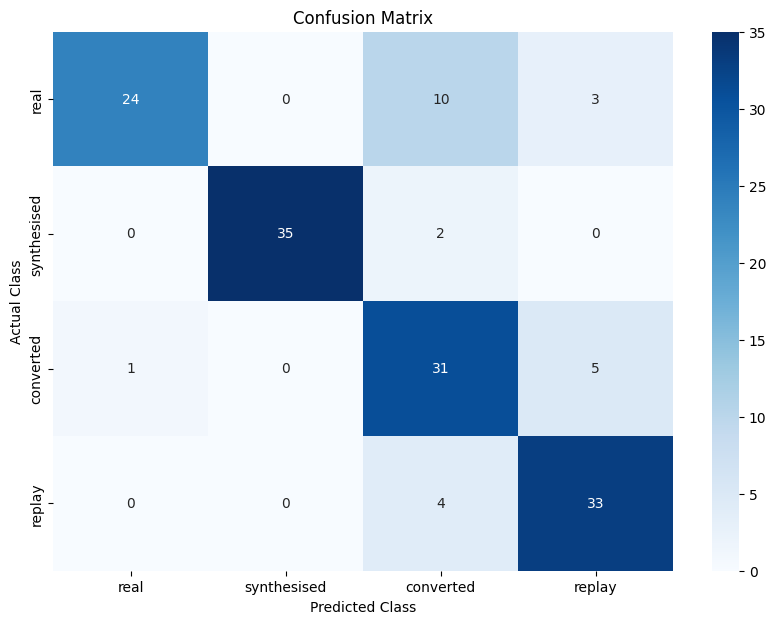

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Perform predictions on the evaluation set
y_test_pred = model.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_test_pred_classes)

# Create a heatmap plot
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')

# Show the plot
plt.show()


# GRU Model

In [17]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report


# Define the architecture of the Sequential GRU model
model_gru = Sequential([
    GRU(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    GRU(128, return_sequences=True),
    Dropout(0.2),
    GRU(128),
    Dropout(0.2),
    Dense(4, activation='softmax')  # Assuming 4 classes for multiclass classification
])

# Compile the model
learning_rate = 0.0001  # Adjust the learning rate as needed

# Compile the model with custom learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model_gru.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])



In [ ]:
# Train the model
history = model_gru.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_val, y_val))

# Evaluate the model
loss, accuracy = model_gru.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')




Epoch 1/100
88/88 [==============================] - 3s 31ms/step - loss: 1.0771 - accuracy: 0.4757 - val_loss: 0.9391 - val_accuracy: 0.4932
Epoch 2/100
88/88 [==============================] - 3s 33ms/step - loss: 0.9632 - accuracy: 0.5371 - val_loss: 0.8983 - val_accuracy: 0.5811
Epoch 3/100
88/88 [==============================] - 3s 34ms/step - loss: 0.9206 - accuracy: 0.5543 - val_loss: 0.7569 - val_accuracy: 0.6622
Epoch 4/100
88/88 [==============================] - 3s 30ms/step - loss: 0.8863 - accuracy: 0.5571 - val_loss: 0.7502 - val_accuracy: 0.6284
Epoch 5/100
88/88 [==============================] - 3s 30ms/step - loss: 0.8433 - accuracy: 0.5857 - val_loss: 0.7084 - val_accuracy: 0.6689
Epoch 6/100
88/88 [==============================] - 3s 29ms/step - loss: 0.8358 - accuracy: 0.6143 - val_loss: 0.6681 - val_accuracy: 0.6689
Epoch 7/100
88/88 [==============================] - 3s 34ms/step - loss: 0.8251 - accuracy: 0.5871 - val_loss: 0.7343 - val_accuracy: 0.6351
Epoch 

In [ ]:
from sklearn.metrics import classification_report, precision_recall_fscore_support
import numpy as np


# Predict probabilities on the test set for multiclass classification
y_pred_prob_multiclass = model_2.predict(X_test)
y_pred_classes_multiclass = np.argmax(y_pred_prob_multiclass, axis=1)

# Convert one-hot encoded test labels back to integer format for multiclass classification
y_test_int = np.argmax(y_test_categorical, axis=1)


# Generate classification report for multiclass classification
report_multiclass = classification_report(y_test_int, y_pred_classes_multiclass, target_names=class_labels)
print("\nMulticlass Classification Report LSTM:")
print(report_multiclass)


5/5 [==============================] - 1s 148ms/step

Multiclass Classification Report LSTM:
              precision    recall  f1-score   support

        real       0.96      0.59      0.73        37
 synthesised       1.00      1.00      1.00        37
   converted       0.75      0.89      0.81        37
      replay       0.84      1.00      0.91        37

    accuracy                           0.87       148
   macro avg       0.89      0.87      0.87       148
weighted avg       0.89      0.87      0.87       148



In [ ]:
model_gru.save('/content/drive/MyDrive/save/voice-spoofing-detection-using-gru-Multiclass.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:

import os
from tensorflow.keras.models import load_model

model_path = "/content/drive/MyDrive/save/voice-spoofing-detection-using-gru-Multiclass.h5"

model_2 = load_model(model_path)

# add code to load model


sample_audio_file_path = "/content/drive/MyDrive/dataset/LA/ASVspoof2019_LA_eval/flac/test.flac"


# Make predictions
sample_audio_spectrogram = audio_to_spectrogram(sample_audio_file_path)

# Assuming the shape of the spectrogram is suitable for the model input
X_new = np.expand_dims(sample_audio_spectrogram, axis=0)

# Performing prediction
y_pred = model_2.predict(X_new)

# Convert probabilities to classes by selecting the class with the highest probability
y_pred_classes = np.argmax(y_pred, axis=1)

# Map predicted classes to labels
class_labels = ['real', 'synthesised', 'converted','replay']  # Update with your actual class labels
y_pred_labels = [class_labels[pred] for pred in y_pred_classes]

print("Predicted class:", y_pred_labels[0])



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
Predicted class: synthesised


In [ ]:
# Compute accuracy on training data
train_accuracy = model_2.evaluate(X_train, y_train)[1]
print(f"Accuracy on training data: {train_accuracy * 100:.2f}%")

# Compute accuracy on validation data
val_accuracy = model_2.evaluate(X_val, y_val)[1]
print(f'Accuracy on validation data: {val_accuracy * 100:.2f}%')

# Compute accuracy on test data
test_accuracy = model_2.evaluate(X_test, y_test)[1]
print(f'Accuracy on test data: {test_accuracy * 100:.2f}%')


22/22 [==============================] - 4s 198ms/step - loss: 0.2151 - accuracy: 0.9243
Accuracy on training data: 92.43%
5/5 [==============================] - 1s 143ms/step - loss: 0.7222 - accuracy: 0.7905
Accuracy on validation data: 79.05%
5/5 [==============================] - 1s 143ms/step - loss: 0.4306 - accuracy: 0.8716
Accuracy on test data: 87.16%


5/5 [==============================] - 0s 23ms/step


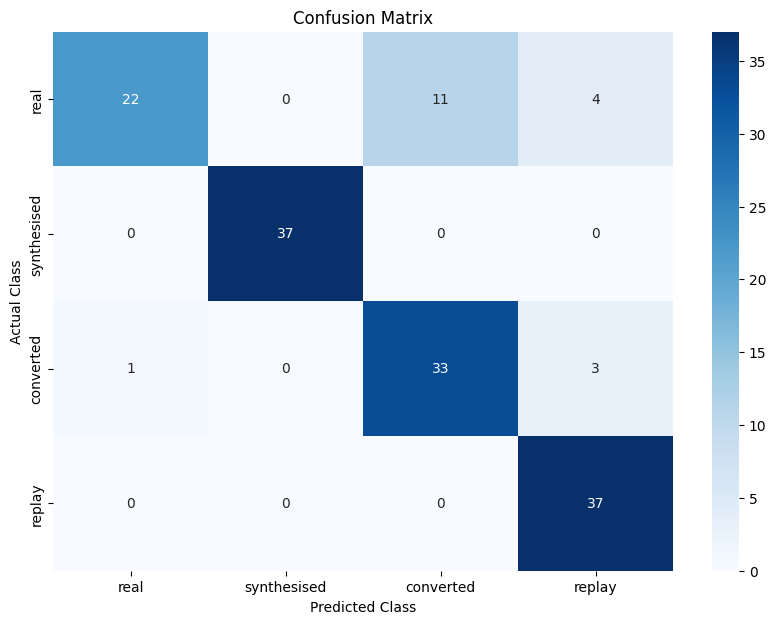

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have X_eval and y_eval datasets for testing

# Perform predictions on the evaluation set
y_eval_pred = model_2.predict(X_eval)
y_eval_pred_classes = np.argmax(y_eval_pred, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_eval, y_eval_pred_classes)

# Create a heatmap plot
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')

# Show the plot
plt.show()


# WaveNet Model


In [19]:
!pip install --upgrade tensorflow-io

In [20]:
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential

def wavenet_model(input_shape, num_classes, dilation_depth=5, kernel_size=3):
    model = Sequential()
    dilation_rates = [2**i for i in range(dilation_depth)]

    for dilation_rate in dilation_rates:
        model.add(Conv1D(32, kernel_size, activation='relu', dilation_rate=dilation_rate, padding='causal'))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

# Reshape input data
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

# Define input shape
input_shape = (X_train.shape[1], X_train.shape[2])  # (num_time_steps, num_frequency_bins)

# Define number of output classes
num_classes = 4  # Update with the actual number of output classes

# Create the WaveNet model with similar architecture to the CNN model
wavenet_model = wavenet_model(input_shape, num_classes, kernel_size=3)


In [21]:
from tensorflow.keras.optimizers import Adam

# Define the learning rate
learning_rate = 0.001  # Adjust this value as needed

# Compile the model with the custom learning rate
optimizer = Adam(learning_rate=learning_rate)
wavenet_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = wavenet_model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_val, y_val))


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 32s 373ms/step - accuracy: 0.2801 - loss: 9.9334 - val_accuracy: 0.4122 - val_loss: 1.2779
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.3641 - loss: 1.3166 - val_accuracy: 0.6149 - val_loss: 1.0511
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5455 - loss: 1.0971 - val_accuracy: 0.6689 - val_loss: 1.0220
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4997 - loss: 1.0844 - val_accuracy: 0.6892 - val_loss: 0.6933
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6012 - loss: 0.8923 - val_accuracy: 0.7973 - val_loss: 0.6098
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6027 - loss: 0.8291 - val_accuracy: 0.7500 - val_loss: 0.4904
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6083 - loss: 0.8025 - val_accuracy: 0.8581 - val_loss: 0.5038
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6240 - loss: 0.8442 - val_accuracy: 0.7095 - val_l

In [22]:
# Save the model
wavenet_model.save('/content/drive/MyDrive/save/voice-spoofing-detection-using-wavenet-Multiclass.h5')

1/5 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 363ms/step


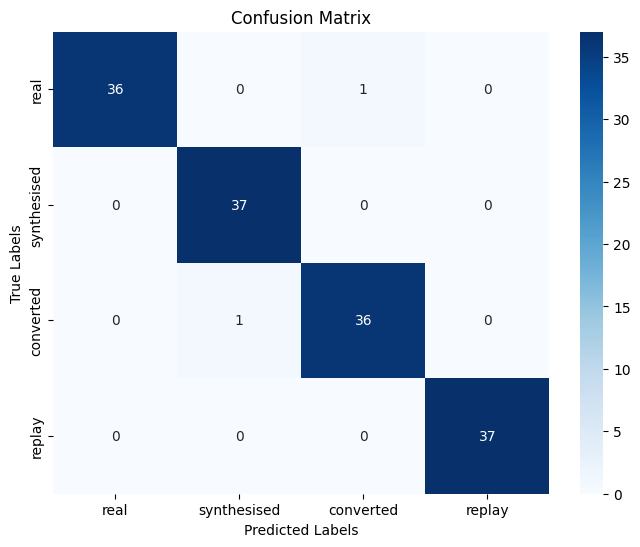

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Perform predictions on the evaluation set
y_test_pred = wavenet_model.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_test_pred_classes)
class_labels = ['real', 'synthesised', 'converted','replay']
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [24]:
# Calculate and print classification report with precision up to 4 decimal points
report = classification_report(y_test, y_test_pred_classes, target_names=class_labels, digits=4)
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

        real     1.0000    0.9730    0.9863        37
 synthesised     0.9737    1.0000    0.9867        37
   converted     0.9730    0.9730    0.9730        37
      replay     1.0000    1.0000    1.0000        37

    accuracy                         0.9865       148
   macro avg     0.9867    0.9865    0.9865       148
weighted avg     0.9867    0.9865    0.9865       148



In [27]:
import os
import numpy as np
from tensorflow.keras.models import load_model
from IPython.display import display, Audio
import ipywidgets as widgets

# Load all models
cnn_bin_path = "/content/drive/MyDrive/save/voice-spoofing-detection-using-cnn.h5"
cnn_model_path = "/content/drive/MyDrive/save/voice-spoofing-detection-using-cnn-Multiclass.h5"
lstm_model_path = "/content/drive/MyDrive/save/voice-spoofing-detection-using-lstm-Multiclass.h5"
gru_model_path = "/content/drive/MyDrive/save/voice-spoofing-detection-using-gru-Multiclass.h5"
wavenet_model_path = "/content/drive/MyDrive/save/voice-spoofing-detection-using-wavenet-Multiclass.h5"

cnn_bin_model = load_model(cnn_bin_path)
cnn_model = load_model(cnn_model_path)
lstm_model = load_model(lstm_model_path)
gru_model = load_model(gru_model_path)
wavenet_model = load_model(wavenet_model_path)


# Function to perform prediction
def predict_audio(audio_file_path):
    # Create spectrogram for the audio file
    audio_spectrogram = audio_to_spectrogram(audio_file_path)
    X_new = np.expand_dims(audio_spectrogram, axis=0)

    # Perform predictions for each model
    y_pred_cnn_bin = cnn_bin_model.predict(X_new)
    y_pred_cnn = cnn_model.predict(X_new)
    y_pred_lstm = lstm_model.predict(X_new)
    y_pred_gru = gru_model.predict(X_new)
    y_pred_wavenet = wavenet_model.predict(X_new)

    # Convert probabilities to classes by selecting the class with the highest probability for each model
    class_labels_bin = ['real', 'fake']
    class_labels_multiclass = ['real', 'synthesised', 'converted', 'replay']

    y_pred_classes_cnn_bin = np.argmax(y_pred_cnn_bin, axis=1)
    y_pred_labels_cnn_bin = [class_labels_bin[pred] for pred in y_pred_classes_cnn_bin]

    y_pred_classes_cnn = np.argmax(y_pred_cnn, axis=1)
    y_pred_labels_cnn = [class_labels_multiclass[pred] for pred in y_pred_classes_cnn]

    y_pred_classes_lstm = np.argmax(y_pred_lstm, axis=1)
    y_pred_labels_lstm = [class_labels_multiclass[pred] for pred in y_pred_classes_lstm]

    y_pred_classes_gru = np.argmax(y_pred_gru, axis=1)
    y_pred_labels_gru = [class_labels_multiclass[pred] for pred in y_pred_classes_gru]

    y_pred_classes_wavenet = np.argmax(y_pred_wavenet, axis=1)
    y_pred_labels_wavenet = [class_labels_multiclass[pred] for pred in y_pred_classes_wavenet]

    # Predict binary class label using the binary CNN model
    y_pred_cnn_bin = cnn_bin_model.predict(X_new)
    binary_class_label = 'real' if y_pred_cnn_bin[0][0] < 0.5 else 'fake'

    # Display the audio and print predictions
    display(Audio(filename=audio_file_path, autoplay=False))
    print("Binary Classification (CNN):", binary_class_label)
    print("Multiclass Classification (CNN):", y_pred_labels_cnn[0])
    print("Multiclass Classification (LSTM):", y_pred_labels_lstm[0])
    print("Multiclass Classification (GRU):", y_pred_labels_gru[0])
    print("Multiclass Classification (WaveNet):", y_pred_labels_wavenet[0])

# Create custom text widget
custom_text = widgets.HTML(value="<h3>Upload an Audio File:</h3>")

# Create file upload widget
uploader = widgets.FileUpload(accept='.wav,.flac', multiple=False)
display(widgets.VBox([custom_text, uploader]))

def on_file_upload(change):
    audio_file_content = list(uploader.value.values())[0]['content']
    audio_file_path = 'uploaded_audio.wav'  # Save the uploaded audio temporarily
    with open(audio_file_path, 'wb') as f:
        f.write(audio_file_content)
    predict_audio(audio_file_path)

uploader.observe(on_file_upload, names='value')

